In [24]:
import os
import numpy as np
import pandas as pd
import cv2
import ast
import matplotlib.pyplot as plt
from PIL import Image
import easyocr
import pytesseract
from jiwer import wer, cer
import seaborn as sns
import random

# Define paths for Kaggle
INPUT_DIR = '/kaggle/input/textocr-text-extraction-from-images-dataset'
IMAGES_DIR = os.path.join(INPUT_DIR, 'train_val_images', 'train_images')
ANNOT_FILE = os.path.join(INPUT_DIR, 'annot.csv')

# Load annotations
print("Loading annotations...")
annotations = pd.read_csv(ANNOT_FILE)

# Convert bbox string to list
def parse_bbox(bbox_str):
    if isinstance(bbox_str, str):
        return ast.literal_eval(bbox_str)
    return bbox_str

annotations['bbox'] = annotations['bbox'].apply(parse_bbox)

# Select 2 random images
all_image_ids = annotations['image_id'].unique()
sample_image_ids = random.sample(list(all_image_ids), 2)
print(f"Selected random image IDs:", sample_image_ids)

# Dictionary to store results for comparison
all_results = {
    'EasyOCR': {'CER': [], 'WER': []},
    'Tesseract': {'CER': [], 'WER': []}
}

Loading annotations...
Selected random image IDs: ['2d604fecdf1d2137', '67e4a759665ea6f1']



Initializing EasyOCR...

Processing with EasyOCR...

Processing image 2d604fecdf1d2137


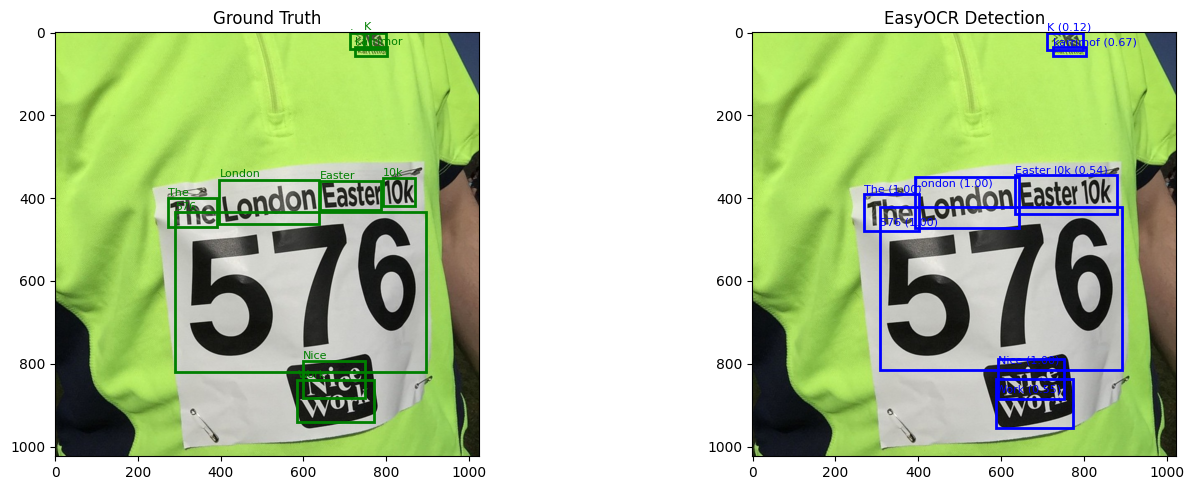


EasyOCR Results:
--------------------------------------------------
Ground Truth: karrimor
EasyOCR: karrimof (confidence: 0.67)
CER: 0.12
WER: 1.00
IoU: 0.83
------------------------------
Ground Truth: K
EasyOCR: K (confidence: 0.12)
CER: 0.00
WER: 0.00
IoU: 0.55
------------------------------
Ground Truth: .
EasyOCR: K (confidence: 0.12)
CER: 1.00
WER: 1.00
IoU: 0.53
------------------------------
Ground Truth: The
EasyOCR: The (confidence: 1.00)
CER: 0.00
WER: 0.00
IoU: 0.68
------------------------------
Ground Truth: London
EasyOCR: London (confidence: 1.00)
CER: 0.00
WER: 0.00
IoU: 0.85
------------------------------
No matching detection found for: Easter
------------------------------
No matching detection found for: 10k
------------------------------
Ground Truth: 576
EasyOCR: 576 (confidence: 1.00)
CER: 0.00
WER: 0.00
IoU: 0.92
------------------------------
Ground Truth: Nice
EasyOCR: Nice (confidence: 1.00)
CER: 0.00
WER: 0.00
IoU: 0.86
------------------------------
Groun

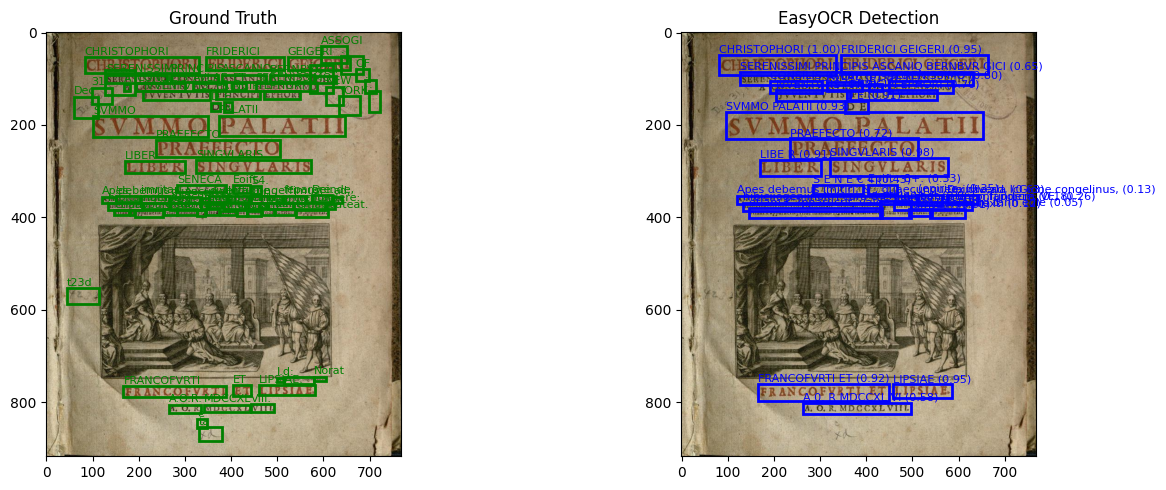


EasyOCR Results:
--------------------------------------------------
Ground Truth: CHRISTOPHORI
EasyOCR: CHRISTOPHORI (confidence: 1.00)
CER: 0.00
WER: 0.00
IoU: 0.77
------------------------------
No matching detection found for: FRIDERICI
------------------------------
No matching detection found for: GEIGERI
------------------------------
No matching detection found for: BERNBVR
------------------------------
No matching detection found for: GICI
------------------------------
No matching detection found for: ASCANIO
------------------------------
No matching detection found for: PRINCIPIS
------------------------------
No matching detection found for: SERENISSIMI
------------------------------
No matching detection found for: A
------------------------------
Ground Truth: CONSILIS
EasyOCR: CONSILIS (confidence: 0.88)
CER: 0.00
WER: 0.00
IoU: 0.61
------------------------------
Ground Truth: AVLAE
EasyOCR: AvLAE (confidence: 0.99)
CER: 0.20
WER: 1.00
IoU: 0.71
----------------------

In [25]:
# Initialize EasyOCR
print("\nInitializing EasyOCR...")
reader = easyocr.Reader(['en'])

# Process with EasyOCR
print("\nProcessing with EasyOCR...")
for img_id in sample_image_ids:
    print(f"\nProcessing image {img_id}")
    
    # Load image
    image_path = os.path.join(IMAGES_DIR, f"{img_id}.jpg")
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get ground truth
    gt_annotations = annotations[annotations['image_id'] == img_id]
    
    # Perform EasyOCR detection
    easyocr_results = reader.readtext(image_rgb)
    
    # Visualize
    plt.figure(figsize=(15, 5))
    
    # Ground truth
    plt.subplot(121)
    plt.imshow(image_rgb)
    for _, row in gt_annotations.iterrows():
        bbox = row['bbox']
        x, y, w, h = [int(coord) for coord in bbox]
        plt.gca().add_patch(plt.Rectangle((x,y), w, h, fill=False, color='green', linewidth=2))
        plt.text(x, y-5, row['utf8_string'], color='green', fontsize=8)
    plt.title('Ground Truth')
    
    # EasyOCR detections
    plt.subplot(122)
    plt.imshow(image_rgb)
    for (bbox, text, prob) in easyocr_results:
        points = np.array(bbox, np.int32)
        x, y = points[0]
        plt.gca().add_patch(plt.Rectangle((min(points[:,0]), min(points[:,1])),
                                        max(points[:,0]) - min(points[:,0]),
                                        max(points[:,1]) - min(points[:,1]),
                                        fill=False, color='blue', linewidth=2))
        plt.text(x, y-5, f"{text} ({prob:.2f})", color='blue', fontsize=8)
    plt.title('EasyOCR Detection')
    
    plt.tight_layout()
    plt.show()
    
    # Inside the EasyOCR processing loop, replace the metrics calculation part with:

    # Calculate metrics
    print("\nEasyOCR Results:")
    print("-" * 50)
    
    # For each ground truth annotation
    for _, gt_row in gt_annotations.iterrows():
        gt_text = gt_row['utf8_string']
        gt_bbox = gt_row['bbox']
        x, y, w, h = [int(coord) for coord in gt_bbox]
        
        # Find the closest OCR detection based on IoU (Intersection over Union)
        best_match = None
        best_iou = 0
        
        for (bbox, ocr_text, prob) in easyocr_results:
            # Convert EasyOCR bbox to x,y,w,h format
            points = np.array(bbox)
            ocr_x = int(min(points[:,0]))
            ocr_y = int(min(points[:,1]))
            ocr_w = int(max(points[:,0]) - min(points[:,0]))
            ocr_h = int(max(points[:,1]) - min(points[:,1]))
            
            # Calculate IoU
            x_left = max(x, ocr_x)
            y_top = max(y, ocr_y)
            x_right = min(x + w, ocr_x + ocr_w)
            y_bottom = min(y + h, ocr_y + ocr_h)
            
            if x_right < x_left or y_bottom < y_top:
                continue
                
            intersection = (x_right - x_left) * (y_bottom - y_top)
            area1 = w * h
            area2 = ocr_w * ocr_h
            union = area1 + area2 - intersection
            iou = intersection / union
            
            if iou > best_iou:
                best_iou = iou
                best_match = (ocr_text, prob)
        
        # Calculate metrics only for the best matching detection
        if best_match and best_iou > 0.5:  # Only consider matches with IoU > 0.5
            ocr_text, prob = best_match
            print(f"Ground Truth: {gt_text}")
            print(f"EasyOCR: {ocr_text} (confidence: {prob:.2f})")
            cer_score = cer(gt_text, ocr_text)
            wer_score = wer(gt_text, ocr_text)
            print(f"CER: {cer_score:.2f}")
            print(f"WER: {wer_score:.2f}")
            print(f"IoU: {best_iou:.2f}")
            print("-" * 30)
            
            all_results['EasyOCR']['CER'].append(cer_score)
            all_results['EasyOCR']['WER'].append(wer_score)
        else:
            print(f"No matching detection found for: {gt_text}")
            print("-" * 30)


Processing with Tesseract...

Processing image 2d604fecdf1d2137


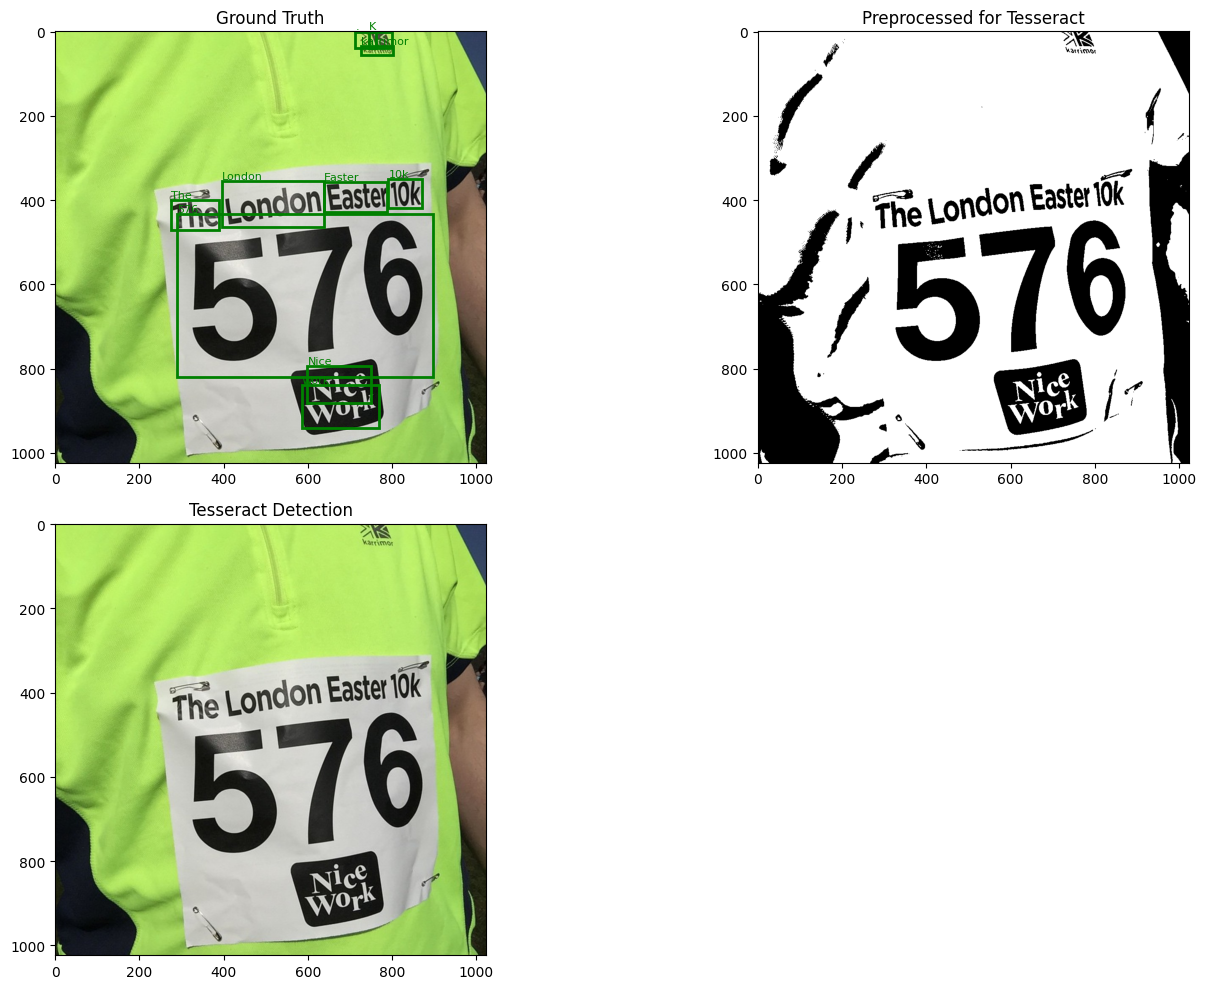


Tesseract Results:
--------------------------------------------------
No matching detection found for: karrimor
------------------------------
No matching detection found for: K
------------------------------
No matching detection found for: .
------------------------------
No matching detection found for: The
------------------------------
No matching detection found for: London
------------------------------
No matching detection found for: Easter
------------------------------
No matching detection found for: 10k
------------------------------
No matching detection found for: 576
------------------------------
No matching detection found for: Nice
------------------------------
No matching detection found for: Work
------------------------------

Processing image 67e4a759665ea6f1


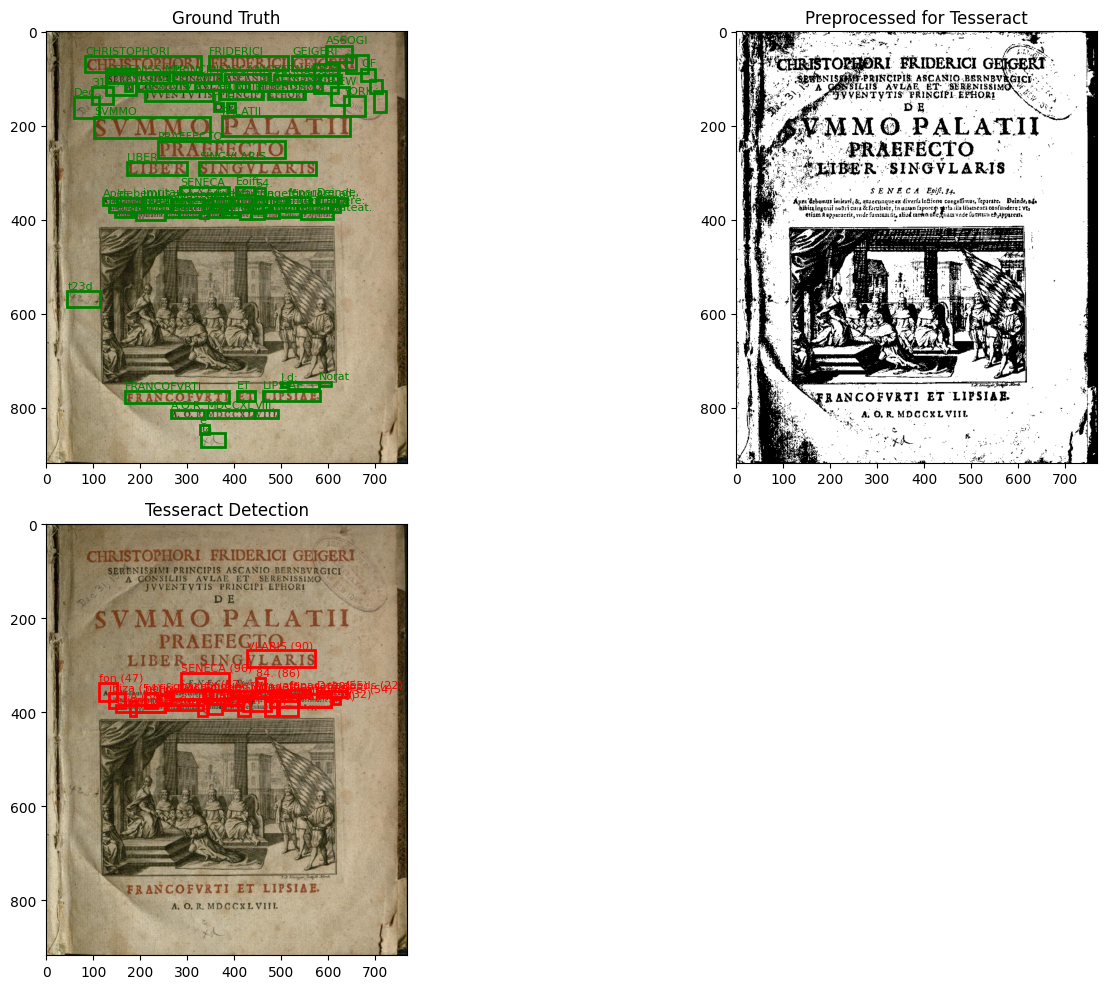


Tesseract Results:
--------------------------------------------------
No matching detection found for: CHRISTOPHORI
------------------------------
No matching detection found for: FRIDERICI
------------------------------
No matching detection found for: GEIGERI
------------------------------
No matching detection found for: BERNBVR
------------------------------
No matching detection found for: GICI
------------------------------
No matching detection found for: ASCANIO
------------------------------
No matching detection found for: PRINCIPIS
------------------------------
No matching detection found for: SERENISSIMI
------------------------------
No matching detection found for: A
------------------------------
No matching detection found for: CONSILIS
------------------------------
No matching detection found for: AVLAE
------------------------------
No matching detection found for: ET
------------------------------
No matching detection found for: SERENISSIMO
----------------------

In [27]:
import os
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np

# Function to preprocess images for Tesseract
def preprocess_for_tesseract(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    denoised = cv2.fastNlMeansDenoising(gray)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(denoised)
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return binary

# Process with Tesseract
print("\nProcessing with Tesseract...")
for img_id in sample_image_ids:
    print(f"\nProcessing image {img_id}")
    
    # Load and preprocess image
    image_path = os.path.join(IMAGES_DIR, f"{img_id}.jpg")
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    processed_img = preprocess_for_tesseract(image)
    
    # Get ground truth annotations
    gt_annotations = annotations[annotations['image_id'] == img_id]
    
    # Perform Tesseract OCR
    tesseract_data = pytesseract.image_to_data(processed_img, output_type=pytesseract.Output.DICT)
    
    # Visualize results
    plt.figure(figsize=(15, 10))
    
    # Ground truth
    plt.subplot(221)
    plt.imshow(image_rgb)
    for _, row in gt_annotations.iterrows():
        bbox = row['bbox']
        x, y, w, h = [int(coord) for coord in bbox]
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, color='green', linewidth=2))
        plt.text(x, y - 5, row['utf8_string'], color='green', fontsize=8)
    plt.title('Ground Truth')
    
    # Preprocessed image
    plt.subplot(222)
    plt.imshow(processed_img, cmap='gray')
    plt.title('Preprocessed for Tesseract')
    
    # Tesseract detections
    plt.subplot(223)
    plt.imshow(image_rgb)
    for i in range(len(tesseract_data['text'])):
        if int(tesseract_data['conf'][i]) > 0:  # Filter out low-confidence results
            x = tesseract_data['left'][i]
            y = tesseract_data['top'][i]
            w = tesseract_data['width'][i]
            h = tesseract_data['height'][i]
            text = tesseract_data['text'][i]
            conf = tesseract_data['conf'][i]
            
            if text.strip():  # Only consider non-empty text
                # Draw bounding box
                plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2))
                # Annotate with text and confidence
                plt.text(x, y - 5, f"{text} ({conf})", color='red', fontsize=8)
    plt.title('Tesseract Detection')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    print("\nTesseract Results:")
    print("-" * 50)
    for _, gt_row in gt_annotations.iterrows():
        gt_text = gt_row['utf8_string']
        gt_bbox = gt_row['bbox']
        best_match = None
        best_iou = 0
        
        for i in range(len(tesseract_data['text'])):
            if int(tesseract_data['conf'][i]) > 0 and tesseract_data['text'][i].strip():
                ocr_text = tesseract_data['text'][i]
                x = tesseract_data['left'][i]
                y = tesseract_data['top'][i]
                w = tesseract_data['width'][i]
                h = tesseract_data['height'][i]
                
                # Calculate IoU
                x1, y1, w1, h1 = [int(coord) for coord in gt_bbox]
                x2, y2, w2, h2 = x, y, w, h
                
                x_left = max(x1, x2)
                y_top = max(y1, y2)
                x_right = min(x1 + w1, x2 + w2)
                y_bottom = min(y1 + h1, y2 + h2)
                
                if x_right < x_left or y_bottom < y_top:
                    continue
                
                intersection = (x_right - x_left) * (y_bottom - y_top)
                area1 = w1 * h1
                area2 = w2 * h2
                union = area1 + area2 - intersection
                iou = intersection / union
                
                if iou > best_iou:
                    best_iou = iou
                    best_match = ocr_text
        
        # Calculate metrics for the best match
        if best_match and best_iou > 0.5:
            print(f"Ground Truth: {gt_text}")
            print(f"Tesseract: {best_match}")
            cer_score = cer(gt_text, best_match)
            wer_score = wer(gt_text, best_match)
            print(f"CER: {cer_score:.2f}")
            print(f"WER: {wer_score:.2f}")
            print(f"IoU: {best_iou:.2f}")
            print("-" * 30)
            all_results['Tesseract']['CER'].append(cer_score)
            all_results['Tesseract']['WER'].append(wer_score)
        else:
            print(f"No matching detection found for: {gt_text}")
            print("-" * 30)


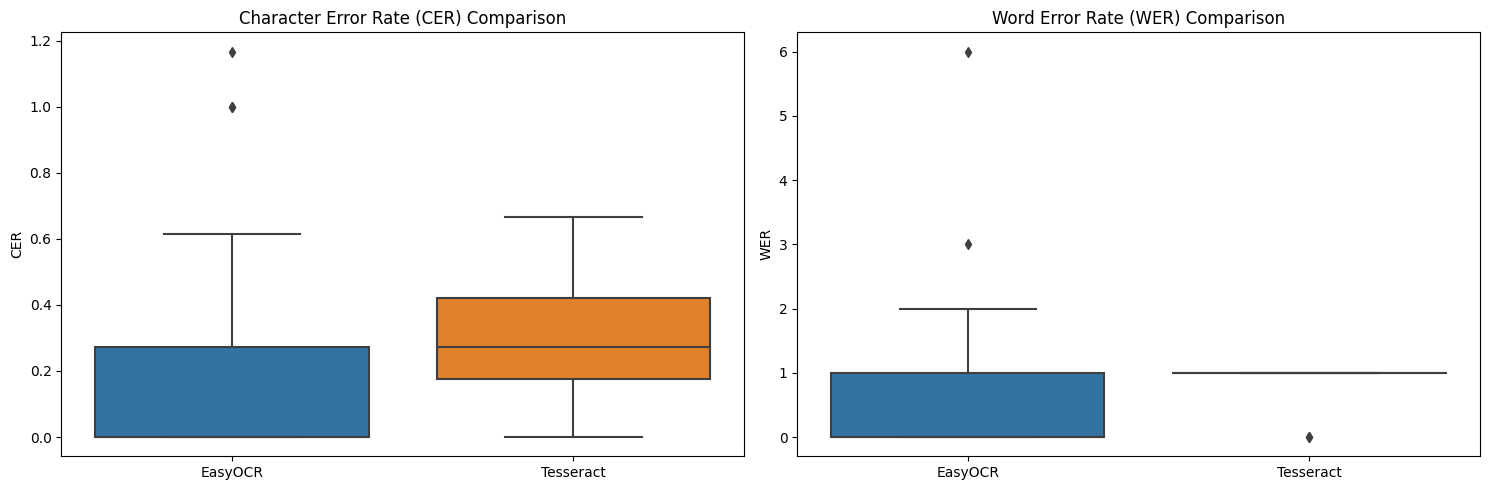


Summary Statistics:
--------------------------------------------------

EasyOCR:
Average CER: 0.22
Average WER: 0.76
Median CER: 0.00
Median WER: 0.00

Tesseract:
Average CER: 0.30
Average WER: 0.93
Median CER: 0.27
Median WER: 1.00


In [28]:
# Visualize comparison
plt.figure(figsize=(15, 5))

# CER Comparison
plt.subplot(121)
plt.title('Character Error Rate (CER) Comparison')
sns.boxplot(data=[all_results['EasyOCR']['CER'], all_results['Tesseract']['CER']])
plt.xticks([0, 1], ['EasyOCR', 'Tesseract'])
plt.ylabel('CER')

# WER Comparison
plt.subplot(122)
plt.title('Word Error Rate (WER) Comparison')
sns.boxplot(data=[all_results['EasyOCR']['WER'], all_results['Tesseract']['WER']])
plt.xticks([0, 1], ['EasyOCR', 'Tesseract'])
plt.ylabel('WER')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("-" * 50)
for model in ['EasyOCR', 'Tesseract']:
    print(f"\n{model}:")
    print(f"Average CER: {np.mean(all_results[model]['CER']):.2f}")
    print(f"Average WER: {np.mean(all_results[model]['WER']):.2f}")
    print(f"Median CER: {np.median(all_results[model]['CER']):.2f}")
    print(f"Median WER: {np.median(all_results[model]['WER']):.2f}")